In [1]:
import numpy as np
import pandas as pd
import pathlib
import seaborn as sns
import scipy.io as sio
import xmltodict

from matplotlib import pyplot as plt
from PIL import Image
from pprint import pprint

In [2]:
%matplotlib inline

## General order of events / goals of this notebook
1. Download the Stanford Dogs dataset to a local gitignored directory
1. Understand the size and shape of the data (class frequencies, etc.)
1. ~Experimenting with resolving individual dog breeds to American Kennel Club breed groups~
1. Testing out how to apply bounding boxes to the images to focus on the dogs that need to be classified
1. Implementing a benchmark RandomGuess model.
1. Moving files around appropriately so that `train`,`test`, and `annotation` folders are organized by class.

## 1. Bringing the data in locally

First, we'll create a directory to hold all the downloaded files

In [3]:
data_dir = pathlib.Path('data')
if not data_dir.exists():
    data_dir.mkdir(exist_ok = False)

##### No need to rerun the next four cells unless you're starting from scratch

Here's how we receive the **list** provided by the researchers that map images to train and test sets

In [4]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar -O data/temp.tar
!tar xofp data/temp.tar -C data
!rm data/temp.tar

--2020-06-17 13:38:01--  http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 481280 (470K) [application/x-tar]
Saving to: ‘data/temp.tar’

data/temp.tar       100%[===================>] 470.00K   607KB/s    in 0.8s    

2020-06-17 13:38:01 (607 KB/s) - ‘data/temp.tar’ saved [481280/481280]



In [8]:
files_downloaded = [x for x in data_dir.glob('*') if x.is_file()]
print(files_downloaded)

[PosixPath('data/file_list.mat'), PosixPath('data/test_list.mat'), PosixPath('data/train_list.mat')]


Noting that these `_list` files are of the `.mat` type, so we'll need to use scipy.io to read them as numpy arrays...

Here's a similar process for the **Annotations** files that contain bounding boxes...

In [9]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar -O data/temp.tar
!tar xofp data/temp.tar -C data
!rm data/temp.tar

--2020-06-17 13:44:48--  http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21852160 (21M) [application/x-tar]
Saving to: ‘data/temp.tar’

data/temp.tar       100%[===================>]  20.84M  5.11MB/s    in 6.0s    

2020-06-17 13:44:54 (3.45 MB/s) - ‘data/temp.tar’ saved [21852160/21852160]



This creates a subdirectory called `data/Annotation` that holds a bunch of really gnarly XML documents that contain the bounding boxes for each particular folder.

Finally, what I would imagine to be the longest download process, we can repeat much the same process for the actual images themselves.

In [10]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar -O data/temp.tar
!tar xofp data/temp.tar -C data
!rm data/temp.tar

--2020-06-17 13:49:23--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘data/temp.tar’

data/temp.tar       100%[===================>] 756.82M  1.33MB/s    in 1m 51s  

2020-06-17 13:51:14 (6.82 MB/s) - ‘data/temp.tar’ saved [793579520/793579520]



This last step took about two minutes to complete, which is good to keep in mind. It's worth noting that in order to play nicely with PyTorch's ImageFolder and DataLoader classes, I may eventually want to have the images reshuffled into `train/<class-label>` and `test/<class-label` folders. I'm not going to handle that right now, though.

## 2. Understanding the size and shape of the data

From a class frequency perspective, I can accomplish this simply by looking at the `file_list.mat`. If I want to take a look at the distribution of image dimensionality, I may need to actually start popping open files.

First, let's load in the basic `file_list` to see what's inside....

In [4]:
full_file_list = sio.loadmat(data_dir / "file_list.mat")
pprint(full_file_list)

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct '
               b' 9 08:29:09 2011',
 '__version__': '1.0',
 'annotation_list': array([[array(['n02085620-Chihuahua/n02085620_10074'], dtype='<U35')],
       [array(['n02085620-Chihuahua/n02085620_10131'], dtype='<U35')],
       [array(['n02085620-Chihuahua/n02085620_10621'], dtype='<U35')],
       ...,
       [array(['n02116738-African_hunting_dog/n02116738_9829'], dtype='<U44')],
       [array(['n02116738-African_hunting_dog/n02116738_9844'], dtype='<U44')],
       [array(['n02116738-African_hunting_dog/n02116738_9924'], dtype='<U44')]],
      dtype=object),
 'file_list': array([[array(['n02085620-Chihuahua/n02085620_10074.jpg'], dtype='<U39')],
       [array(['n02085620-Chihuahua/n02085620_10131.jpg'], dtype='<U39')],
       [array(['n02085620-Chihuahua/n02085620_10621.jpg'], dtype='<U39')],
       ...,
       [array(['n02116738-African_hunting_dog/n02116738_9829.jpg'], dtype='<U48')],


There should be 20,580 annotations within `annotation_list`, files within `file_list` and `labels`, and indeed there are.

In [4]:
for key in ["annotation_list", "file_list", "labels"]:
    print(f"Count of {key}: {full_file_list[key].flatten().size}")
    print()

Count of annotation_list: 20580

Count of file_list: 20580

Count of labels: 20580



**Note**: While I didn't copy-paste any code directly from it, I want to acknowledge [this Medium post](https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce) as particularly influential with respect to the types of visuals I _did_ end up making to explore this data.

### Part 1: Class distribution

Here's a simple way to get at the appropriate counts across _both train and test sets_...

In [6]:
breed_labels, breed_counts = np.unique(full_file_list["labels"].flatten(), 
                                       return_counts = True)
print(breed_labels, breed_counts)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120] [152 185 252 149 214 188 196 172 172 239 175 195 187 171 159 153 157 148
 151 218 182 187 188 196 151 200 232 160 155 164 182 172 179 169 172 185
 164 157 197 202 202 197 196 180 182 154 157 155 158 206 183 156 169 186
 152 151 150 171 167 152 154 161 155 153 152 150 159 150 159 151 150 150
 154 150 150 152 153 154 169 157 153 150 150 152 152 150 184 168 218 151
 202 151 156 152 159 156 170 150 178 192 150 209 200 210 195 213 218 219
 196 158 153 181 155 151 155 159 155 156 150 169]


The only other thing we'd need to make the visual a bit more clear is the actual _names_ that the numeric labels correspond to. We should be able to get this as follows ...

In [5]:
def get_breed_name(file_name_arr):
    return [x.item(0).split("/")[0].split("-")[1] for x in file_name_arr]

def map_breed_labels_to_names(file_list):
    name_label_map = {}
    name_list = np.apply_along_axis(get_breed_name, 0, file_list)
    unique_names, og_indexes = np.unique(name_list, return_index = True)
    for i, name in enumerate(unique_names[np.argsort(og_indexes)]):
        name_label_map[i + 1] = name
    return name_label_map

In [8]:
labels_to_breeds = map_breed_labels_to_names(file_list = full_file_list["file_list"])

In [9]:
labels_to_breeds

{1: 'Chihuahua',
 2: 'Japanese_spaniel',
 3: 'Maltese_dog',
 4: 'Pekinese',
 5: 'Shih',
 6: 'Blenheim_spaniel',
 7: 'papillon',
 8: 'toy_terrier',
 9: 'Rhodesian_ridgeback',
 10: 'Afghan_hound',
 11: 'basset',
 12: 'beagle',
 13: 'bloodhound',
 14: 'bluetick',
 15: 'black',
 16: 'Walker_hound',
 17: 'English_foxhound',
 18: 'redbone',
 19: 'borzoi',
 20: 'Irish_wolfhound',
 21: 'Italian_greyhound',
 22: 'whippet',
 23: 'Ibizan_hound',
 24: 'Norwegian_elkhound',
 25: 'otterhound',
 26: 'Saluki',
 27: 'Scottish_deerhound',
 28: 'Weimaraner',
 29: 'Staffordshire_bullterrier',
 30: 'American_Staffordshire_terrier',
 31: 'Bedlington_terrier',
 32: 'Border_terrier',
 33: 'Kerry_blue_terrier',
 34: 'Irish_terrier',
 35: 'Norfolk_terrier',
 36: 'Norwich_terrier',
 37: 'Yorkshire_terrier',
 38: 'wire',
 39: 'Lakeland_terrier',
 40: 'Sealyham_terrier',
 41: 'Airedale',
 42: 'cairn',
 43: 'Australian_terrier',
 44: 'Dandie_Dinmont',
 45: 'Boston_bull',
 46: 'miniature_schnauzer',
 47: 'giant_schn

This `labels_to_breeds` mapping should be consistent across the train and test lists as well. More importantly in the immediate term, we can use it to provide axis labels to our `breed_counts` from earlier.

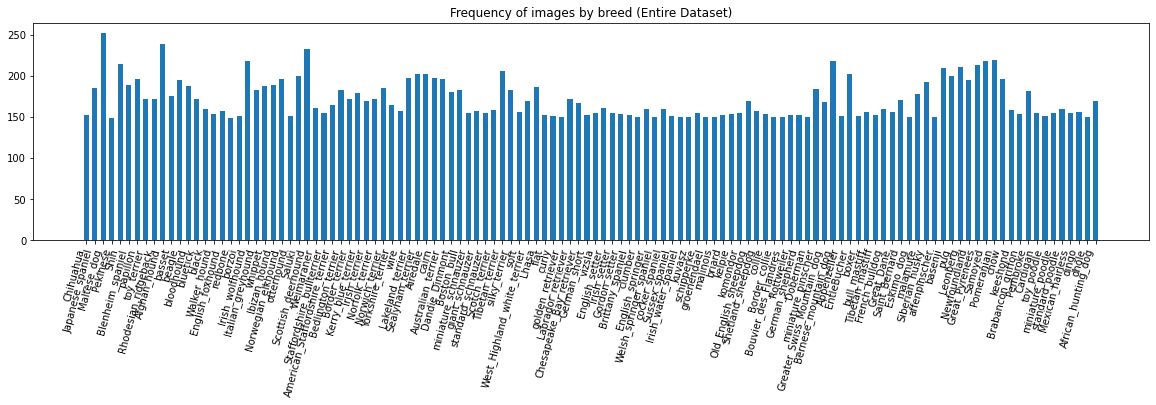

In [11]:
fig, ax = plt.subplots(figsize = (20,4))
plt.bar(x = breed_labels.tolist(), 
        height = breed_counts.tolist(),
        width = 0.6,
        align = 'center')
plt.xticks(ticks = breed_labels.tolist(),
          labels = [labels_to_breeds[k] for k in breed_labels.tolist()],
          rotation = 75,
          ha = 'right')
plt.title("Frequency of images by breed (Entire Dataset)")
plt.show()

So, while this isn't the most legible plot I've ever made in my life, we can see at a glance that **most of our 120 breeds are represented by somewhere between 150 and 200 images** across both train and test sets.

In [12]:
over200breeds = breed_labels[np.where(breed_counts > 200)].tolist()
for label in over200breeds:
    print(f"{labels_to_breeds[label]} has {breed_counts[label - 1]} images")

Maltese_dog has 252 images
Shih has 214 images
Afghan_hound has 239 images
Irish_wolfhound has 218 images
Scottish_deerhound has 232 images
Sealyham_terrier has 202 images
Airedale has 202 images
Tibetan_terrier has 206 images
Bernese_mountain_dog has 218 images
EntleBucher has 202 images
basenji has 209 images
Leonberg has 210 images
Great_Pyrenees has 213 images
Samoyed has 218 images
Pomeranian has 219 images


In [13]:
under150breeds = breed_labels[np.where(breed_counts < 150)].tolist()
for label in under150breeds:
    print(f"{labels_to_breeds[label]} has {breed_counts[label - 1]} images")

Pekinese has 149 images
redbone has 148 images


What's perhaps most important for us to consider is what this distribution looks like in the _training_ set...

In [6]:
train_file_list = sio.loadmat(data_dir / "train_list.mat")
train_labels, train_counts = np.unique(train_file_list["labels"].flatten(), 
                                       return_counts = True)

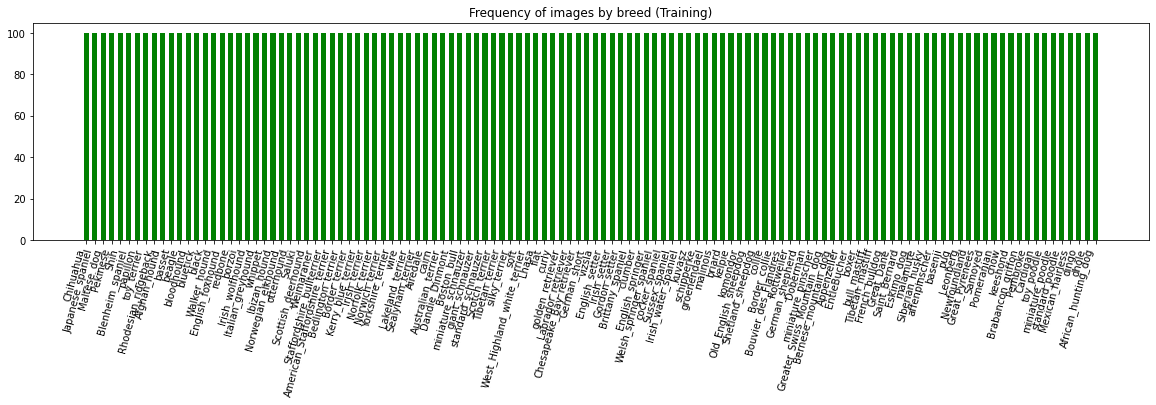

In [16]:
fig, ax = plt.subplots(figsize = (20,4))
plt.bar(x = train_labels.tolist(), 
        height = train_counts.tolist(),
        width = 0.6,
        color = 'green',
        align = 'center')
plt.xticks(ticks = train_labels.tolist(),
          labels = [labels_to_breeds[k] for k in train_labels.tolist()],
          rotation = 75,
          ha = 'right')
plt.title("Frequency of images by breed (Training)")
plt.show()

It's important to note here that the **training instances are perfectly balanced across each of our 120 breeds.** That is to say, we have 100 training images for each of the breeds we want to predict.

This makes me skeptical as to whether my proposed third step of resolving individual breeds to breed groups is actually going to be necessary: we have a good number of training instances in each category, and particularly if we need to set up our `train` and `test` directories differently to set up for training, I wouldn't want to take this step lightly.

For the time being, I might skip my proposed mapping of breeds to working groups, and only come back to it if something goes horrendously wrong with the breed-level predicitons.

### Part 2: Image Size distribution

What I'd ultimately like to try and do here is take a look at the height and width of each of our images, just to understand how uniform they are in size.

Let's start by just looking at a test image...

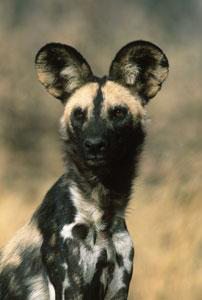

In [19]:
test_jpg = "n02116738-African_hunting_dog/n02116738_9829.jpg"
test_path = data_dir / "Images" / test_jpg
test_img = Image.open(test_path)
display(test_img)

The `size` attribute of a PIL image apparently returns a `(width, height)` tuple...

In [20]:
test_img.size

(202, 300)

So if we iterate through the files in our global `file_list`, extract the heights and widths of each image, and then save them to a temporary dataframe, we should be able to relatively quickly visualize the joint distribution of each `(height, width)` pair.

In [25]:
hw_dicts = []
for jpg_ext in full_file_list["file_list"].flatten():
    test_path = data_dir / "Images" / jpg_ext.item(0)
    test_img = Image.open(test_path)
    hw_dicts.append({"width": test_img.size[0], "height":test_img.size[1]})
hw_df = pd.DataFrame(data = hw_dicts)

In [26]:
hw_df.shape

(20580, 2)

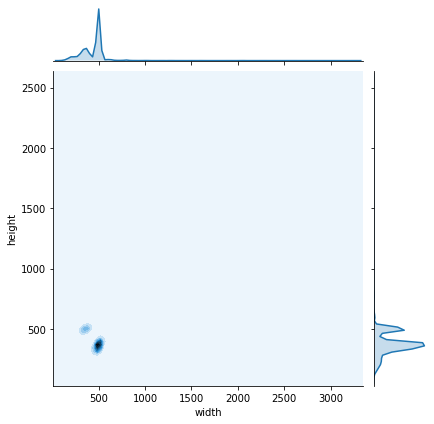

In [38]:
sns.jointplot(x = "width", y = "height", data = hw_df, kind = "kde")

Cool, so apparently we a handful of outlier images that are really big, which is kind of messing up this visual a bit.

In [28]:
hw_df.describe()

,width,height
count,20580.000000,20580.000000
mean,442.531876,385.861224
std,142.792308,124.863446
min,97.000000,100.000000
25%,361.000000,333.000000
50%,500.000000,375.000000
75%,500.000000,453.000000
max,3264.000000,2562.000000


But if we boot out all images that are smaller thant `1000 X 1000`, we're still keeping 99% of our data.

In [34]:
len(hw_df.loc[(hw_df.height < 1000) & (hw_df.width < 1000)])

20429

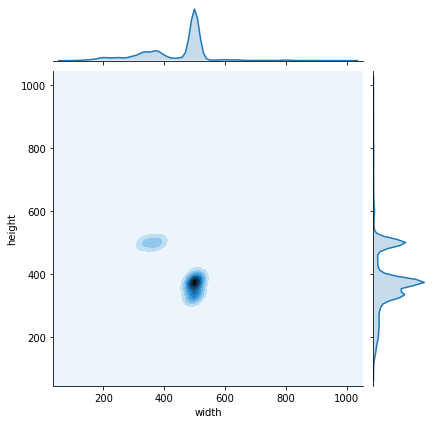

In [37]:
sns.jointplot(x = "width", y = "height", 
              data = hw_df.loc[(hw_df.height < 1000) & (hw_df.width < 1000)], 
              kind = "kde")

This is the clearest indication we have so far that **most of our images are in the 500 X 350** size range. There's a much smaller contingent of images that are essentially the transpose of that: **350 X 500**.

Of course, one thing to keep in mind here is that this is before we applied the bounding boxes...

## 3. Cropping Train and Test Images Down to Bounding Boxes

In [7]:
test_jpg = "n02116738-African_hunting_dog/n02116738_9829.jpg"
test_path = data_dir / "Images" / test_jpg

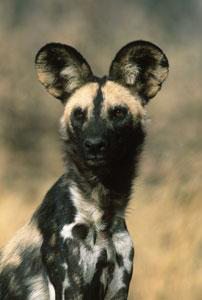

In [8]:
display(Image.open(test_path))

In [24]:
train_file_list['file_list'].flatten()[-2]

array(['n02116738-African_hunting_dog/n02116738_9333.jpg'], dtype='<U48')

In [28]:
def get_image_path(file_name_arr, root_dir):
    file_path = file_name_arr.item()
    return pathlib.Path(root_dir) / "Images" / file_path


def get_annotation_path(file_name_arr, root_dir):
    file_path = pathlib.Path(file_name_arr.item())
    annot_file_name = file_path.stem
    breed_dir = file_path.parent.stem
    return pathlib.Path(root_dir) / "Annotation" / breed_dir / annot_file_name

In [20]:
get_annotation_path(file_name_arr = train_file_list['file_list'].flatten()[0], 
                    root_dir = data_dir).is_file()

True

In [22]:
get_image_path(file_name_arr = train_file_list['file_list'].flatten()[0],
               root_dir = data_dir).is_file()

True

In [25]:
def extract_bbox_coords(annot_path):
    with open(annot_path, "r") as fd:
        raw_xml = xmltodict.parse(fd.read())
    box = raw_xml["annotation"]["object"]["bndbox"]
    left = int(box["xmin"])
    upper = int(box["ymin"])
    right = int(box["xmax"])
    lower = int(box["ymax"])
    return (left, upper, right, lower)

This is a horrifying chihuaua...

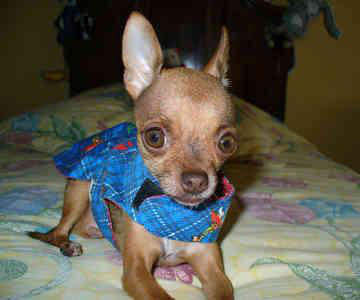

In [26]:
foo_file = train_file_list['file_list'].flatten()[0]
foo_img = get_image_path(file_name_arr = foo_file, root_dir = 'data')
display(Image.open(foo_img))

In [29]:
foo_annot = get_annotation_path(file_name_arr = foo_file, root_dir = 'data')
extract_bbox_coords(foo_annot)

(30, 14, 236, 298)

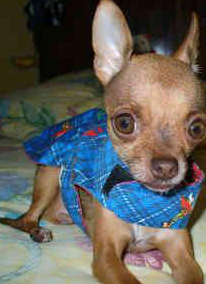

In [30]:
display(Image.open(foo_img).crop(box = extract_bbox_coords(foo_annot)))